In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

torch.manual_seed(1) # 可重复使用的随机seed
np.random.seed(1)

In [10]:
# Hyper parmeters
BATCH_SIZE = 64
LR_G = 1e-4  # learning rate of generator
LR_D = 1e-4  # learning rate of discriminator
N_IDEAS = 5  # think of this as number of ideas for generating an art work (Generator)？
ART_COMPONENTS = 15  # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

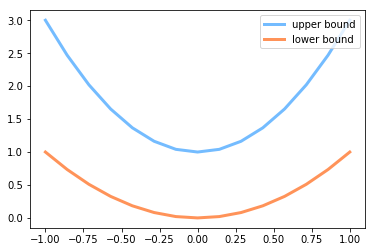

In [6]:
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [20]:
# painting from the famous artist (real target)
def artist_works():
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a - 1)
    paintings = torch.from_numpy(paintings).float()
    return Variable(paintings)

# Generator
G = nn.Sequential(
    nn.Linear(N_IDEAS, 128),  # random ideas
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),  # making a pointing from these random ideas
)

# Discriminator
D = nn.Sequential(
    nn.Linear(ART_COMPONENTS, 128),  # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),  # tell the probability that the art work is made by artist
)

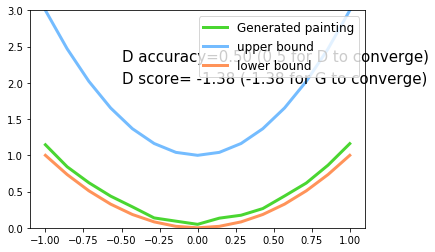

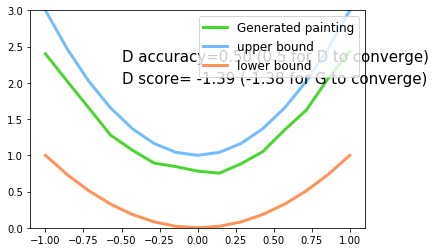

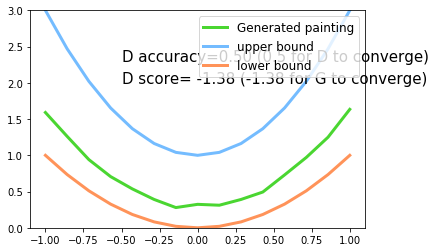

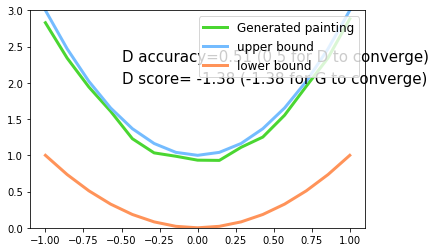

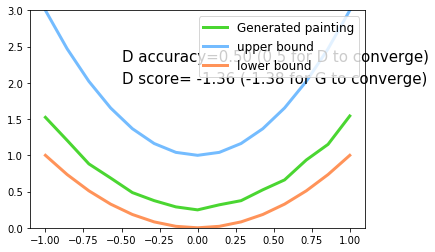

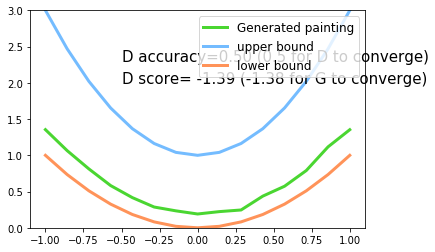

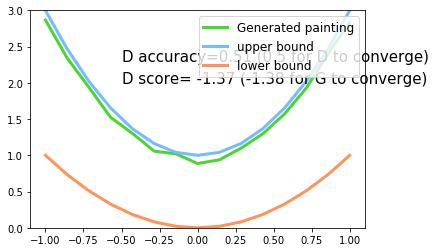

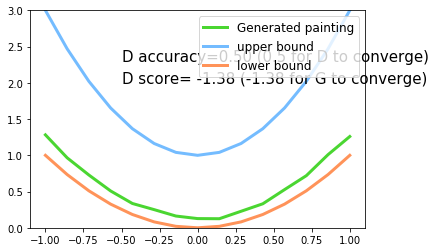

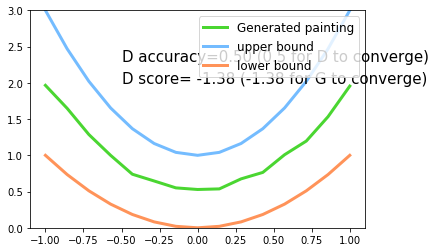

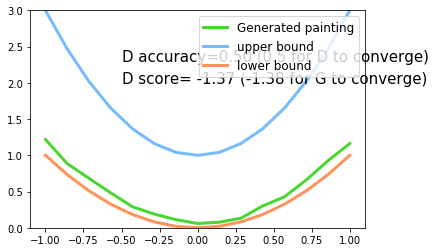

In [25]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

for step in range(10000):
    artist_paintings = artist_works()
    G_ideas = Variable(torch.randn(BATCH_SIZE, N_IDEAS))
    G_paintings = G(G_ideas)
    
    # 这里的两个概率都是指“认为该画是著名作家”这一事件的概率
    prob_artist0 = D(artist_paintings)
    prob_artist1 = D(G_paintings)
    
    # Discriminator想要最大化猜对的次数，由于pytorch中只能最小化某个损失函数，因此使用负号转化成求最小值
    D_loss = -torch.mean(torch.log(prob_artist0) + torch.log(1 - prob_artist1))
    # Generator想要最大化骗过Discriminator的次数，也就是最大化将G产生的画猜作名画的可能性
    G_loss = torch.mean(torch.log(1 - prob_artist1))
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if(step % 1000 == 0):
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 15})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=12);plt.draw();plt.pause(0.01)
        plt.show()